In [1]:
import pandas as pd
import numpy as np
seed = np.random.seed

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error


### Dataset analysis

In [2]:
X_train_ori = pd.read_csv('./data/X_train.csv')
y_train_ori = pd.read_csv('./data/y_train.csv')

X_test_ori = pd.read_csv('./data/X_test.csv')
print(X_train_ori.shape)
print(X_train_ori.columns)
print(y_train_ori.columns)
print('Class labels:', np.unique(y_train_ori))
X_train_ori.head()

(85751, 8)
Index(['PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME',
       'SHOT_DIST', 'PTS_TYPE', 'CLOSE_DEF_DIST'],
      dtype='object')
Index(['FGM'], dtype='object')
Class labels: [0 1]


,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST
0,1,358,2.4,0,3.2,20.6,2,4.5
1,1,585,8.3,0,1.2,3.0,2,0.5
2,1,540,19.9,0,0.6,3.5,2,3.2
3,1,392,9.0,0,0.9,21.1,2,4.9
4,3,401,22.7,0,0.7,4.1,2,2.9


### We don't have y_test this time, need to split a validation set for checking performance

In [3]:
X_train, X_val, y_train, y_val = train_test_split(X_train_ori, y_train_ori, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [4]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(64313, 8) (64313, 1)
(21438, 8) (21438, 1)


### - Random Forest Classifier

In [109]:
# Train a RandomForestClassifier as model 
forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=200, 
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train)

print('#Training data points: %d' % X_train.shape[0])
print('#Testing data points: %d' % X_val.shape[0])

y_train_pred = forest.predict(X_train)
y_valid_pred = forest.predict(X_val)

print('Train Accuracy (Random forest): %.2f' % accuracy_score(y_train, y_train_pred))
print('valid Accuracy (Random forest): %.2f' % accuracy_score(y_val, y_valid_pred))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


#Training data points: 64313
#Testing data points: 21438
Train Accuracy (Random forest): 1.00
valid Accuracy (Random forest): 0.60


 - Random forest is overfitting

### - Decision tree classifier

In [124]:
# Train a RandomForestClassifier as model 
tree = DecisionTreeClassifier(criterion='entropy',
                                max_depth=4, 
                                random_state=0)
tree.fit(X_train, y_train)

print('#Training data points: %d' % X_train.shape[0])
print('#Testing data points: %d' % X_val.shape[0])

y_train_pred = tree.predict(X_train)
y_valid_pred = tree.predict(X_val)

print('Train Accuracy (Decision tree): %.2f' % accuracy_score(y_train, y_train_pred))
print('valid Accuracy (Decision tree): %.2f' % accuracy_score(y_val, y_valid_pred))

#Training data points: 64313
#Testing data points: 21438
Train Accuracy (Decision tree): 0.61
valid Accuracy (Decision tree): 0.61


- Decision tree has a good accuracy without feature selection: 61%

### Computing Feature Importance

In [27]:
importances = forest.feature_importances_
# get sort indices in descending order
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            X_train.columns.values[indices[f]], 
                            importances[indices[f]]))


 1) GAME_CLOCK                     0.205362
 2) SHOT_DIST                      0.195250
 3) SHOT_CLOCK                     0.188259
 4) CLOSE_DEF_DIST                 0.167823
 5) TOUCH_TIME                     0.140839
 6) PERIOD                         0.048811
 7) DRIBBLES                       0.047166
 8) PTS_TYPE                       0.006490


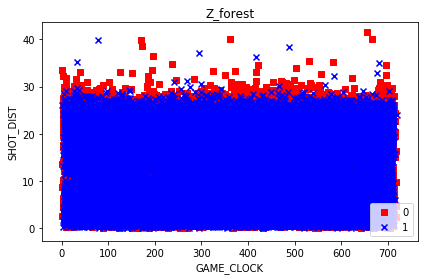

In [111]:
Z_forest = X_train[['GAME_CLOCK', 'SHOT_DIST', 'SHOT_CLOCK']].values

colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
y_ = y_train.iloc[:, 0]
for l, c, m in zip(np.unique(y_.values), colors, markers):
    plt.scatter(Z_forest[y_.values==l, 0], 
                Z_forest[y_.values==l, 1], 
                c=c, label=l, marker=m)

plt.title('Z_forest')
plt.xlabel('GAME_CLOCK')
plt.ylabel('SHOT_DIST')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### train a decision tree based on Z_forest

In [112]:
Z_forest_train, Z_forest_test, y_forest_train, y_forest_test = train_test_split(
    Z_forest, y_train, test_size=0.3, random_state=0)

display(Z_forest.shape)

(64313, 3)

In [115]:
tree_ = DecisionTreeClassifier(criterion='entropy', 
                                     max_depth=3, 
                                     random_state=0)
tree_.fit(Z_forest_train, y_forest_train)

y_train_pred = tree_.predict(Z_forest_train)
y_valid_pred = tree_.predict(Z_forest_test)

print('train Accuracy (Decision Tree): %.2f' % accuracy_score(y_forest_train, y_train_pred))
print('valid Accuracy (Decision Tree): %.2f' % accuracy_score(y_forest_test, y_valid_pred))
print('Accuracy per feature: %.2f' % (accuracy_score(y_forest_test, y_forest_pred)/Z_forest.shape[1]))

train Accuracy (Decision Tree): 0.61
valid Accuracy (Decision Tree): 0.61
Accuracy per feature: 0.20


- Decision tree has a good accuracy with feature selection: 61%
- 這麼做並不會提高準確率，所以接下來的模型將利用原始資料。

### - Linear Regression with threshold=0.5

In [132]:
lr = LinearRegression()

lr.fit(X_train, y_train)

y_train_pred = np.where(lr.predict(X_train) >= 0.5, 1, 0)
y_valid_pred = np.where(lr.predict(X_val) >= 0.5, 1, 0)

print('train Accuracy (Linear Regression): %.2f' % accuracy_score(y_train, y_train_pred))
print('valid Accuracy (Linear Regression): %.2f' % accuracy_score(y_val, y_valid_pred))

train Accuracy (Linear Regression): 0.61
valid Accuracy (Linear Regression): 0.61


- Linear Regression also has a good accuracy : 61%

### - Polynomial Regression

In [20]:
MSE_train = []
MSE_test = []
acc_train = []
acc_test = []

MAX_degree = 5


for d in range(1, MAX_degree):
    poly = PolynomialFeatures(degree=d)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_val)
    
    regr = LinearRegression()
    regr = regr.fit(X_train_poly, y_train)
    y_train_pred = regr.predict(X_train_poly)
    y_test_pred = regr.predict(X_test_poly)
    
    MSE_train.append(mean_squared_error(y_train, y_train_pred))
    MSE_test.append(mean_squared_error(y_val, y_test_pred))


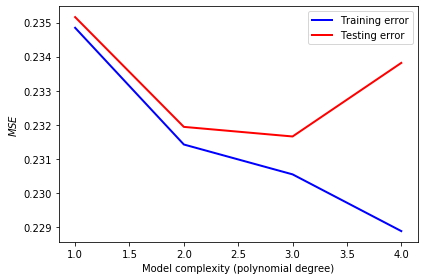

In [21]:
plt.plot(range(1, MAX_degree), MSE_train, label = 'Training error', color = 'blue', linewidth = 2)
plt.plot(range(1, MAX_degree), MSE_test, label = 'Testing error', color = 'red', linewidth = 2)
plt.legend(loc='upper right')
plt.xlabel('Model complexity (polynomial degree)')
plt.ylabel('$MSE$')
plt.tight_layout()
plt.show()

- Mean square error 在 degree 大於 3 之後開始遞增。
- 最小的 testing error 在 degree 為 3。

In [30]:
acc_train = []
acc_test = []

MAX_degree = 6


for d in range(1, MAX_degree):
    poly = PolynomialFeatures(degree=d)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_val)
    
    regr = LinearRegression()
    regr = regr.fit(X_train_poly, y_train)
    y_train_pred = np.where(regr.predict(X_train_poly) >= 0.5, 1, 0)
    y_test_pred = np.where(regr.predict(X_test_poly) >= 0.5, 1, 0)
    
    acc_train.append(accuracy_score(y_train, y_train_pred))
    acc_test.append(accuracy_score(y_val, y_test_pred))
    print('degree:',d)
    print('train Accuracy (PolynomialRegression): %.3f' % accuracy_score(y_train, y_train_pred))
    print('valid Accuracy (PolynomialRegression): %.3f' % accuracy_score(y_val, y_test_pred))
    print("\n")
    
    MSE_train.append(mean_squared_error(y_train, y_train_pred))
    MSE_test.append(mean_squared_error(y_val, y_test_pred))

degree: 1
train Accuracy (PolynomialRegression): 0.607
valid Accuracy (PolynomialRegression): 0.610


degree: 2
train Accuracy (PolynomialRegression): 0.616
valid Accuracy (PolynomialRegression): 0.616


degree: 3
train Accuracy (PolynomialRegression): 0.618
valid Accuracy (PolynomialRegression): 0.615


degree: 4
train Accuracy (PolynomialRegression): 0.620
valid Accuracy (PolynomialRegression): 0.614


degree: 5
train Accuracy (PolynomialRegression): 0.625
valid Accuracy (PolynomialRegression): 0.613




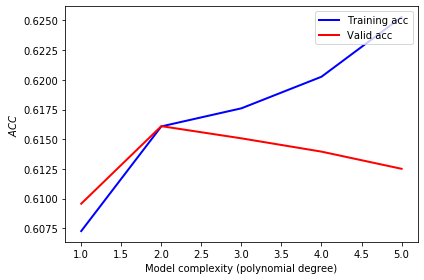

In [31]:
plt.plot(range(1, MAX_degree), acc_train, label = 'Training acc', color = 'blue', linewidth = 2)
plt.plot(range(1, MAX_degree), acc_test, label = 'Valid acc', color = 'red', linewidth = 2)
plt.legend(loc='upper right')
plt.xlabel('Model complexity (polynomial degree)')
plt.ylabel('$ACC$')
plt.tight_layout()
plt.show()

- Polynomial Regression have a best accuracy 61.6% wihch degree=2